# Assemble the catalog of bright stars with spurious detections

Give Elena a list of positions and magnitudes, and a limiting magnitude (-2.5log(z)) to pass to KS2

In [2]:
from pathlib import Path

In [3]:
import re
import numpy as np
import random

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

In [5]:
from astropy.io import fits
from astropy import visualization as viz
import pandas as pd

In [6]:
from importlib import reload
from utils import ks2_utils, shared_utils, image_utils

In [7]:
figpath = Path("./figs/ks2_bright_stars/")

# INPUT.KS2

In [8]:
ks2_filtermapper = ks2_utils.get_filter_mapper()

In [9]:
ks2_filemapper = ks2_utils.get_file_mapper()

# LOGR.XYVIQ1

LOGR.XYVIQ1 gives the average position for each source on the master frame (cols 1 and 2), the average flux (cols 5 and 11), the flux sigma (cols 6 and 12), and fit quality (cols 7 and 13) in each filter)

This is also known as the "master" catalog

In [10]:
reload(ks2_utils)
mast_cat = ks2_utils.get_master_catalog(raw=False)

In [11]:
mast_cat.head()

,umast0,vmast0,mmast1,NMAST,zmast1,szmast1,q1,o1,f1,g1,zmast2,szmast2,q2,o2,f2,g2
0,736.37,91.51,-2.3045,R0000001,8.352,2.586,0.900,0.01,9,9,14.088,1.538,0.963,0.01,9,9
1,737.04,34.36,-3.2771,R0000002,20.458,2.260,0.899,0.00,9,9,9.987,2.508,0.909,0.00,16,16
2,740.65,61.26,-5.9669,R0000003,243.655,3.332,0.999,0.01,9,9,177.850,2.386,0.999,0.02,9,9
3,745.91,93.19,-2.9646,R0000004,15.340,1.092,0.968,0.01,9,9,19.786,2.601,0.982,0.01,9,9
4,749.93,124.75,-4.4803,R0000005,61.959,3.305,0.997,0.00,9,9,84.200,2.850,0.998,0.00,18,18


# LOGR.FIND_NIMFO


In [12]:
reload(ks2_utils)
ps_cat = ks2_utils.get_point_source_catalog(raw=False)

/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (20,28,34) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [13]:
ps_cat.head(5)

,umast,vmast,magu,utile,vtile,z0,sz0,f0,g0,u1,...,o3,f3,g3,NMAST,ps_tile_id,tile_id,exp_id,filt_id,unk,chip_id
0,736.424,91.482,-2.0238,0.0,0.0,6.5,0.8,0,1,31.849,...,0.0,1,1,R0000001,L005,N001,G004,F1,C,1
1,736.459,91.452,-1.4531,0.0,0.0,3.7,0.8,0,1,31.918,...,0.0,1,1,R0000001,L005,N002,G006,F1,C,1
2,736.323,91.491,-2.5450,0.0,0.0,10.4,0.8,0,1,31.646,...,0.0,1,1,R0000001,L005,N003,G007,F1,C,1
3,736.306,91.445,-2.2584,0.0,0.0,8.3,0.8,0,1,31.611,...,0.0,1,1,R0000001,L005,N004,G009,F1,C,1
4,736.398,91.671,-2.5036,0.0,0.0,9.6,0.8,0,1,31.797,...,0.0,1,1,R0000001,L005,N005,G010,F1,C,1


# Do NOT cut on ndet, q, or z - you need to know if a source has been rejected for some reason

In [14]:
# reload(ks2_utils)
# ps_cat = ks2_utils.catalog_cut_ndet(ps_cat, 10)

In [15]:
# query = ' and '.join([f"z{i} > 0" for i in ks2_utils.phot_method_ids])
# query += 'and ' + ' and '.join([f"q{i} > 0" for i in ks2_utils.phot_method_ids])
# ps_cat = ps_cat.query(query)

# Start collecting the brightest stars and their neighbors

In [16]:
exp_id = random.choice(ps_cat['exp_id'].unique())

In [17]:
exp_df = ps_cat.query("exp_id == @exp_id").copy()

In [18]:
exp_df.sort_values(by='o2', inplace=True, ascending=False)

In [19]:
exp_img = ks2_utils.get_img_from_ks2_file_id(exp_id)

## Plot o and z distributions

Is there any correlation with crowding that you can use to select the worst offenders?

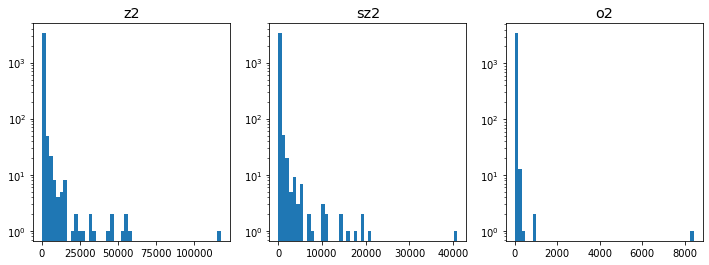

In [20]:
# this doesn't work because some of the values need to be plotted on log
#g = sns.pairplot(exp_df[['z2','sz2','o2']], diag_kind='hist', diag_kws={'bins':50})

nrows = 1
ncols = 3

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

hist_args = {'bins':50, 'log':True}

ax = axes[0]
ax.set_title("z2")
ax.hist(exp_df['z2'], **hist_args);

ax = axes[1]
ax.set_title("sz2")
ax.hist(exp_df['sz2'], **hist_args);

ax = axes[2]
ax.set_title("o2")
ax.hist(exp_df['o2'], **hist_args);

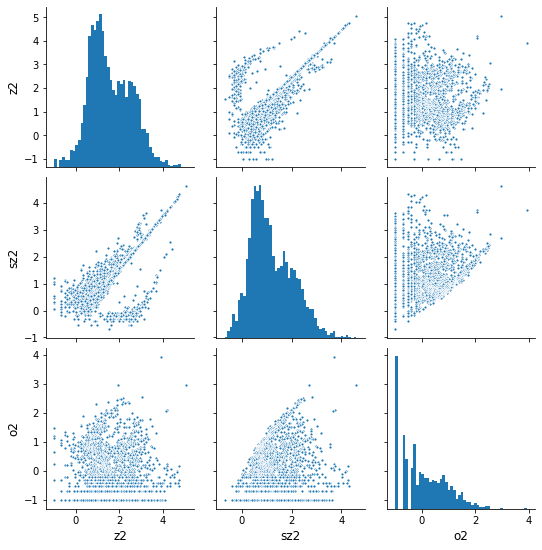

In [21]:
# do correlation plots
nrows = 3
ncols = 3


#fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))

hist_args = {'bins':50, 'log':False}
scat_args = {'marker': '.', 's':10}

labels = ['z2','sz2','o2']
query_str = ' and '.join([f"{i} > 0" for i in labels[:-1]])
tmp_df = exp_df[labels].query(query_str).apply(np.log10, axis=1)
tmp_df[tmp_df.apply(np.isinf)] = np.nan
# tmp_df = tmp_df.query("o2 > 0")

g = sns.pairplot(tmp_df, markers='.',
                 #grid_kws={'marker':'.', 's':10},
                 diag_kws={'bins': 50})

if False:
    fig.savefig(figpath / "o-z-pairplot.png")

## get the brightest star, and its neighbors, and plot and label

In [22]:
brightest_ind = exp_df['z2'].sort_values(ascending=False).index

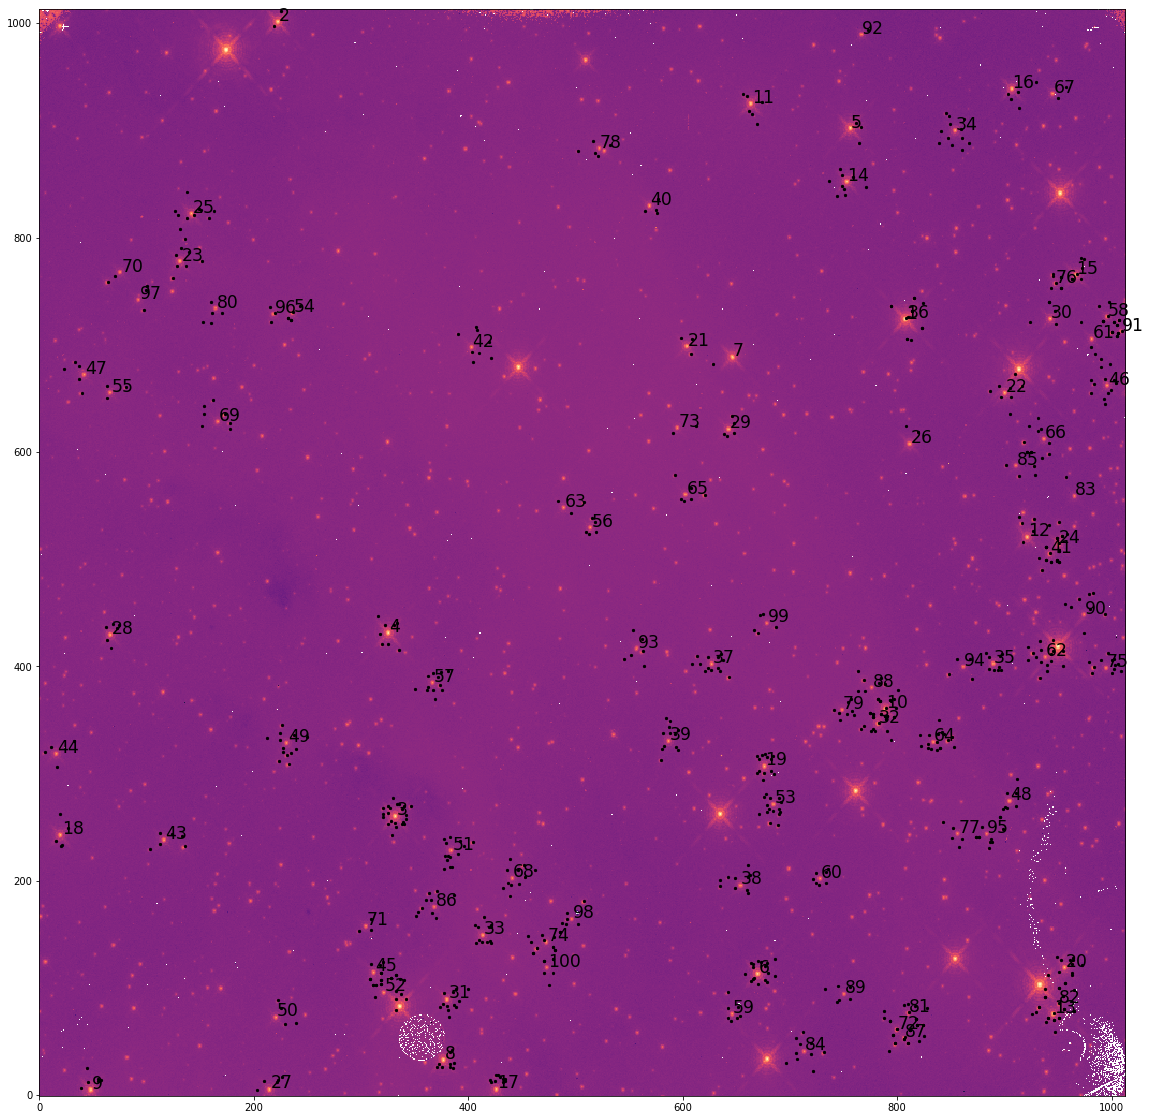

In [23]:
# row = exp_df.loc[brightest_ind[0]]
# neighbors = ks2_utils.get_exposure_neighbors(exp_df, row['NMAST'], row['exp_id'], 11)

img_args = {'norm': mpl.colors.LogNorm(),
            'cmap': mpl.cm.magma,
           }

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(exp_img, **img_args)


nstars = 100
start = 0
for i, ind in enumerate(brightest_ind[start:start+nstars]):
    row = exp_df.loc[ind]
#     ax.scatter(row['xraw1'], row['yraw1'], marker='o', s=100, c='none', ec='w')
    ax.annotate(f"{i+start+1}", row[['xraw1','yraw1']], fontsize='xx-large')
    
    neighbors = ks2_utils.get_exposure_neighbors(exp_df, row['NMAST'], row['exp_id'], 21)
    for n, neighbor in neighbors.iterrows():
        ax.scatter(neighbor['xraw1'], neighbor['yraw1'], 
                   marker='.', s=20, c='k')

ax.set_xlim(0, exp_img.shape[1]-1);
ax.set_xlim(0, exp_img.shape[0]-1);

if False:
    fig.savefig(figpath / f"top_{nstars}_brightest_stars-{exp_id}.png")

# New idea - what if we work up from the bottom with the crowding parameter?

In [24]:
sorted_ind = exp_df['o2'].sort_values(ascending=True).index

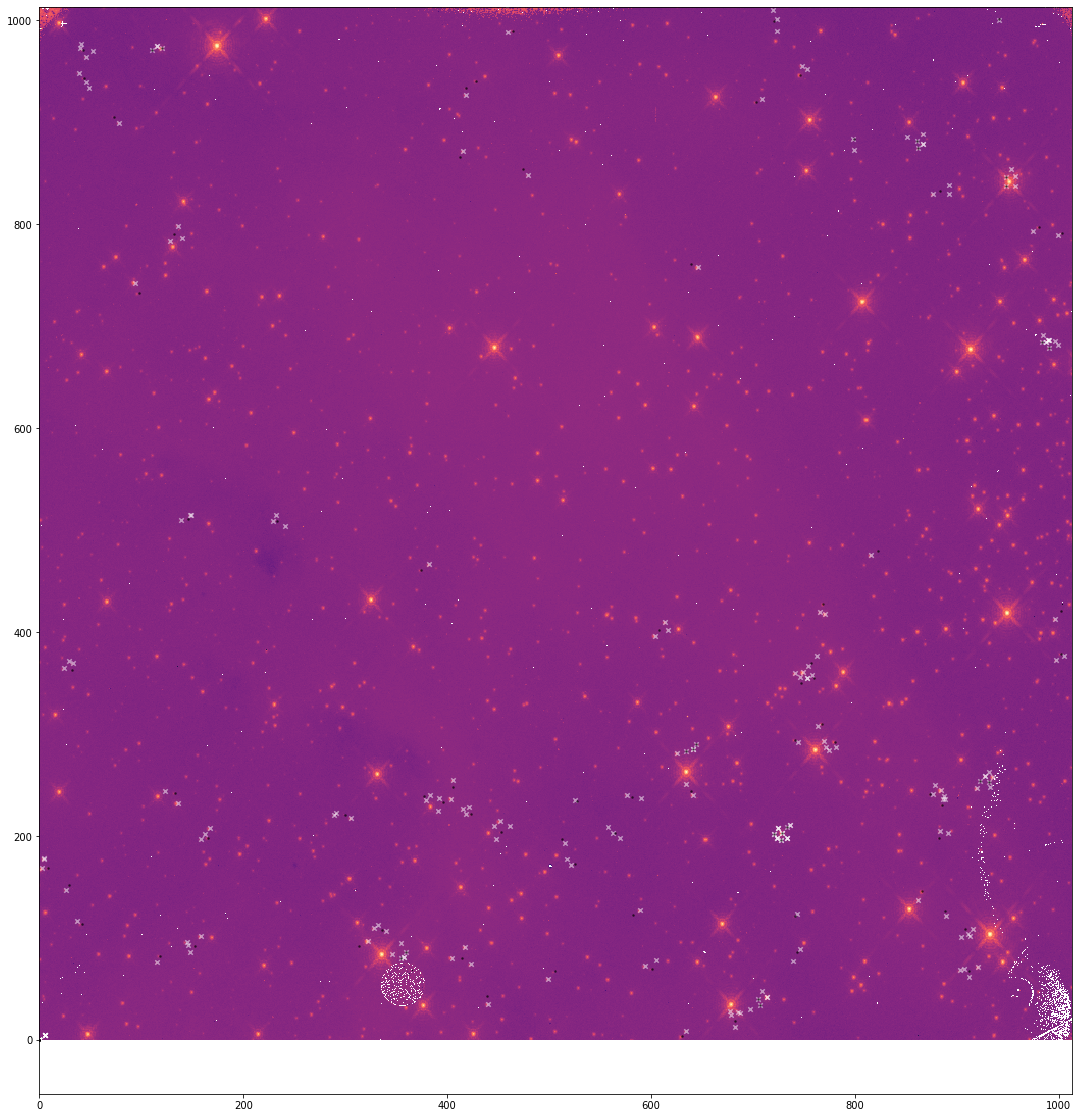

In [25]:
# row = exp_df.loc[brightest_ind[0]]
# neighbors = ks2_utils.get_exposure_neighbors(exp_df, row['NMAST'], row['exp_id'], 11)

img_args = {'norm': mpl.colors.LogNorm(),
            'cmap': mpl.cm.magma,
           }

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(exp_img, **img_args, zorder=-1)


nstars = 100
start = 2000
for i, ind in enumerate(sorted_ind[start:start+nstars]):
    row = exp_df.loc[ind]
    ax.scatter(row['xraw1'], row['yraw1'], marker='.', s=10, c='k', zorder=1, alpha=0.5)
#     ax.annotate(f"{i+start+1}", row[['xraw1','yraw1']], fontsize='xx-large')
    
    neighbors = ks2_utils.get_exposure_neighbors(exp_df, row['NMAST'], row['exp_id'], 11)
    for n, neighbor in neighbors.iterrows():
        ax.scatter(neighbor['xraw1'], neighbor['yraw1'], 
                   marker='x', s=20, c='w', zorder=0, alpha=0.5)

ax.set_xlim(0, exp_img.shape[1]-1);
ax.set_xlim(0, exp_img.shape[0]-1);

if False:
    fig.savefig(figpath / f"least_crowded_{nstars}-{exp_id}.png")

# There must be a better approach. What about in the master frame, with the master catalog?

Make sure the master catalog is updated with the cuts!

In [26]:
ps_cat_cut = ks2_utils.catalog_cut_ndet(ps_cat, 10)
print(len(ps_cat) - len(ps_cat_cut))

2799


In [27]:
mast_cat_cut = mast_cat[mast_cat['NMAST'].isin(ps_cat_cut['NMAST'].unique())]
print(len(mast_cat), len(mast_cat_cut))

6194 5882


In [28]:
mast_cat_cut.columns

Index(['umast0', 'vmast0', 'mmast1', 'NMAST', 'zmast1', 'szmast1', 'q1', 'o1',
       'f1', 'g1', 'zmast2', 'szmast2', 'q2', 'o2', 'f2', 'g2'],
      dtype='object')

In [29]:
mast_cat_cut[['o1','o2']].min().min()

0.0

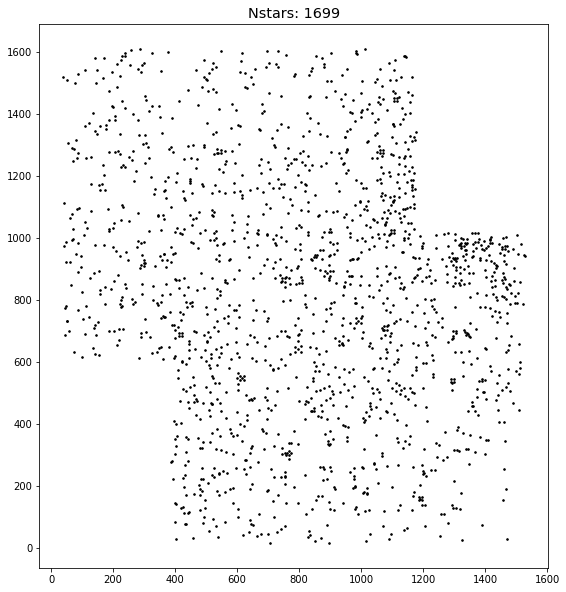

In [30]:
# same but cut on z
fig, ax = plt.subplots(1, 1, figsize=(10,10))

z_max = mast_cat_cut[['zmast1','zmast2']].max().max()
z_min = mast_cat_cut[['zmast1','zmast2']].min().min()
z_lb = z_max/1000
z_ub = z_max
query_str = f"zmast1 <= {z_ub} and zmast2 <= {z_ub} and zmast1 >= {z_lb} and zmast2 >= {z_lb}"
tmp_df = mast_cat_cut.query(query_str)

ax.set_title(f"Nstars: {len(tmp_df)}")
ax.scatter(tmp_df['umast0'], tmp_df['vmast0'],
           marker='.', s=10, c='k')
ax.set_aspect('equal')

No, that's not going to work either. I think the best thing to do is use *stamps*
Go 100 stars at a time and plot the stamp with neighbors!

# Stamps

The idea here is to start from the *master* list. Starting from the brightest star, pull out every stamp for that star, along with its neighbors. Then plot every stamp, along with neighbors, for each star, and work your way down until you stop getting crowded stars

In [31]:
# sort by the F127M filter, or 'F1'
bright_ind = mast_cat_cut.sort_values(by='zmast2', ascending=False).index

R0003688


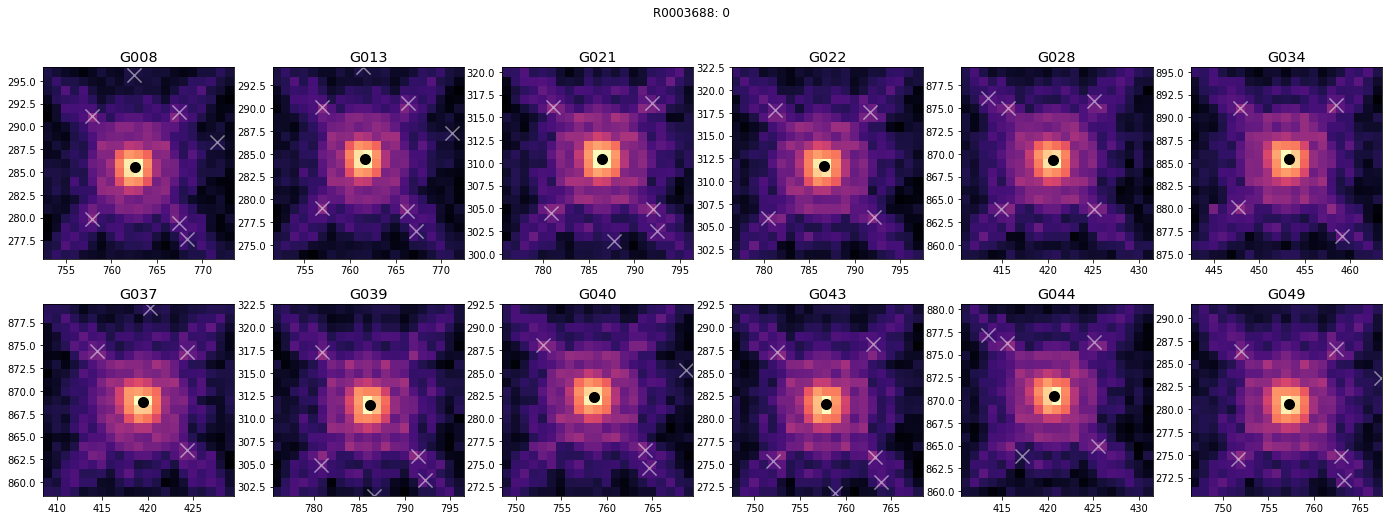

In [50]:
rank = 0
star_name = mast_cat_cut.loc[bright_ind[rank]]['NMAST']
star_rows = ps_cat_cut.query("NMAST == @star_name")

neighbor_dfs = []
stamp_size = 21
for i, row in star_rows.iterrows():
    neighbor_dfs.append(pd.concat([pd.DataFrame([row]),
                                   ks2_utils.get_exposure_neighbors(ps_cat_cut, 
                                                                    row['NMAST'], 
                                                                    row['exp_id'], 
                                                                    stamp_size/2)]).reset_index())
    
print(star_name)

ncols = 6
nrows = np.int(np.ceil(len(neighbor_dfs)/ncols))

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(4*ncols, 4*nrows))
fig.suptitle(f"{star_name}: {rank}")

# turn off extra axes
for ax in axes.flat[len(neighbor_dfs):]:
    ax.set_visible(False)

# ok, do the plots
for i, df in enumerate(neighbor_dfs):
    ax = axes.flat[i]
    
    stamp, stamp_coord = ks2_utils.get_stamp_from_ks2(df.loc[0], stamp_size=stamp_size, return_img_ind=True)
    y, x = image_utils.make_pcolor_index(stamp_coord)
    ax.pcolor(x, y, stamp, norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
    ax.set_aspect('equal')
    # now plot the star and its neighbors
    ax.scatter(df.loc[0]['xraw1'], df.loc[0]['yraw1'], 
               marker='.', s=400, c='k')
    ax.scatter(df.loc[1:]['xraw1'], df.loc[1:]['yraw1'], 
               marker='x', s=200, c='w', alpha=0.5)
    
    ax.set_xlim(*x[[0,-1]])
    ax.set_ylim(*y[[0,-1]])
    ax.set_title(df.loc[0, 'exp_id'])
    
if False:
    fig.savefig(figpath /f"stamps-{star_name}-all_exp_and_neighbors.png")

In [ ]:
# set mag limit and check the plot


In [354]:
# For all stars, plot brightness rank against number of neighbors

In [397]:
# def count_all_neighbors(star_name, cat, search_rad=21):
#     """
#     Accepts a star name a point source catalog, and a search radius
#     Returns the average number of neighbors found in each stamp
#     """
#     star_rows = cat.query("NMAST == @star_name")
#     neighbors = 0
#     for i, row in star_rows.iterrows():
#         neighbors += ks2_utils.get_exposure_neighbors(ps_cat_cut, 
#                                                       row['NMAST'], 
#                                                       row['exp_id'], 
#                                                       stamp_size/2).shape[0]
#     return neighbors/len(star_rows)
    

In [398]:
# count_all_neighbors(star_name, ps_cat_cut, 21)

In [399]:
# n_neighbors = mast_cat_cut.apply(lambda x: count_all_neighbors(x['NMAST'], ps_cat_cut, 21), axis=1)

In [400]:
# n_neighbors

In [33]:
bright_star_cutoff = 359
zcut = np.floor(mast_cat_cut.loc[bright_ind[bright_star_cutoff]]['zmast2'])

In [34]:
zcut, -2.5*np.log10(zcut)

(1700.0, -8.076122303445686)

In [435]:
bright_mast_cat = mast_cat.query("zmast2 >= @zcut and zmast1 > 0")

In [436]:
bright_ps_cat = ps_cat[ps_cat['NMAST'].isin(bright_mast_cat['NMAST'])]

In [437]:
bright_ps_cat.head()

,umast,vmast,magu,utile,vtile,z0,sz0,f0,g0,u1,...,o3,f3,g3,NMAST,ps_tile_id,tile_id,exp_id,filt_id,unk,chip_id
107,754.760,70.368,-8.5739,0.0,0.0,0.0,99999.0,0,0,68.519,...,0.1,1,1,R0000007,L012,N002,G006,F1,C,1
108,754.789,70.360,-8.5556,0.0,0.0,0.0,99999.0,0,0,68.578,...,0.0,1,1,R0000007,L012,N003,G007,F1,C,1
109,754.766,70.349,-8.5910,0.0,0.0,0.0,99999.0,0,0,68.532,...,0.1,1,1,R0000007,L012,N006,G012,F1,C,1
110,754.748,70.365,-8.5836,0.0,0.0,0.0,99999.0,0,0,68.496,...,0.1,1,1,R0000007,L012,N007,G014,F1,C,1
111,754.759,70.370,-8.5934,0.0,0.0,0.0,99999.0,0,0,68.517,...,0.1,1,1,R0000007,L012,N009,G018,F1,C,1


In [438]:
bright_mast_cat.head()

,umast0,vmast0,mmast1,NMAST,zmast1,szmast1,q1,o1,f1,g1,zmast2,szmast2,q2,o2,f2,g2
5,754.79,70.36,-8.5803,R0000007,2704.709,35.819,1.0,0.13,5,5,3227.365,47.837,1.000,0.19,9,9
19,834.77,43.73,-8.3215,R0000022,2131.079,17.199,1.0,0.15,9,9,2200.292,131.793,1.000,0.12,18,18
23,851.87,24.28,-8.5383,R0000027,2602.082,28.601,1.0,0.28,9,9,3326.361,43.047,1.000,0.27,18,18
46,478.68,122.41,-10.3423,R0000052,13706.654,83.366,1.0,0.31,9,9,12035.349,227.745,0.998,0.29,18,18
70,619.22,42.81,-8.2500,R0000076,1995.323,21.318,1.0,0.22,9,9,2009.481,31.924,0.999,0.17,9,9


In [439]:
bright_mast_cat.columns

Index(['umast0', 'vmast0', 'mmast1', 'NMAST', 'zmast1', 'szmast1', 'q1', 'o1',
       'f1', 'g1', 'zmast2', 'szmast2', 'q2', 'o2', 'f2', 'g2'],
      dtype='object')

In [453]:
bright_mast_cat_mag = bright_mast_cat.apply(lambda x: pd.Series([x['umast0'], 
                                                                 x['vmast0'],
                                                                 -2.5*np.log10(x['zmast1']),
                                                                 -2.5*np.log10(x['zmast2'])],
                                                                index=['umast0', 'vmast0', 
                                                                       'mag_filter1', 'mag_filter2'],
                                                               ),
                                            axis=1)

In [455]:
csv_args = {'sep': ',', 'encoding':'ascii', 'index':False}
bright_mast_cat_mag.to_csv(shared_utils.ks2_path / "bright_stars-LOGR.XYVIQ1-nodup.csv", **csv_args)
bright_ps_cat.to_csv(shared_utils.ks2_path / "bright_stars-LOGR.FIND_NIMFO-nodup.csv", **csv_args)